In [158]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt

import numpy as np
import matplotlib.pyplot as plt
import pandas
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression

In [76]:
df_price = pd.read_csv('data/player_price.csv')
df_stats = pd.read_csv('data/player_stats.csv')
sample_subm = pd.read_csv('data/kaggle_sample_submission.csv')

sample_subm["player_id"] = sample_subm["id"].apply(lambda x: int(x.split("_")[0]))
sample_subm["Date"] = sample_subm["id"].apply(lambda x: np.datetime64(x.split("_")[1]))

#player_id=df_price.groupby(['player_id'])['xbox_price'].count()
player_id=sample_subm.groupby(['player_id'])['price'].count()

#df_price=df_price[df_price.player_id<=18320]
df_price['Date'] = pd.to_datetime(df_price['timestamp'], unit='ms')
df_price.drop(['timestamp'], axis=1, inplace=True)
df_price.drop(['ps_price'],axis = 1, inplace=True)
df_price.rename(columns={'xbox_price':'price'}, inplace = True)

df_merge=df_stats[["player_id"]].merge(df_price, on=['player_id'], how='inner')

df_merge.shape

(980252, 4)

In [172]:
def mape(y_pred,y_true):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [77]:
df_new_data=df_merge[df_merge.Date>='2017-05-22']
df_new_data.head()

,player_id,price,player_name,Date
241,1,2971810,Pelé,2017-05-22
242,1,2925575,Pelé,2017-05-23
243,1,2909955,Pelé,2017-05-24
244,1,2918560,Pelé,2017-05-25
245,1,2974671,Pelé,2017-05-26


In [254]:
df_new_data_player=df_new_data[df_new_data.player_id==1]
print(df_new_data_player.shape)
df_new_data_player.tail(7)

(32, 4)


,player_id,price,player_name,Date
266,1,3212762,Pelé,2017-06-16
267,1,3312852,Pelé,2017-06-17
268,1,3227893,Pelé,2017-06-18
269,1,3142655,Pelé,2017-06-19
270,1,3135387,Pelé,2017-06-20
271,1,3248943,Pelé,2017-06-21
272,1,3137143,Pelé,2017-06-22


In [255]:
df=df_new_data_player[['Date','price']]
df=df.groupby('Date')[['price']].mean()
df=df.reset_index()
df.columns = ['ds', 'y']
df=df.set_index('ds')
#df=df.replace(0,int(df.mean()))
print(df.shape)
df.tail()

(32, 1)


,y
ds,
2017-06-18,3227893
2017-06-19,3142655
2017-06-20,3135387
2017-06-21,3248943
2017-06-22,3137143


In [299]:
data=df
x_data = []
y_data = []

for d in range(1,data.shape[0]):
    x = data.iloc[d-1:d].values.ravel()
    y = data.iloc[d].values[0]
    x_data.append(x)
    y_data.append(y)

In [300]:
x_data = np.array(x_data)
y_data = np.array(y_data)

In [301]:
#Lists to store the predictions of the models
y_pred = []
y_pred_last = []
y_pred_ma = []
y_true = []

In [302]:
y_data.shape[0]

31

In [304]:
#Iterate over the time series creating a new model each month
end = y_data.shape[0]
for i in range(1,end):

    x_train = x_data[:i,:]
    y_train = y_data[:i]
    
    x_test = x_data[i,:]
    y_test = y_data[i]


    model = LinearRegression(normalize=True)
    model.fit(x_train,y_train)

    y_pred.append(model.predict(x_test.reshape(1, -1))[0])
    y_pred_last.append(x_test[-1])
    y_pred_ma.append(x_test.mean())
    y_true.append(y_test)

In [ ]:
#Transforms the lists into numpy arrays
y_pred = np.array(y_pred)
y_pred_last = np.array(y_pred_last)
y_pred_ma = np.array(y_pred_ma)
y_true = np.array(y_true)

In [284]:
y_pred

array([ 2925575.        ,  2904677.95014599,  2915195.84903647,
        2924820.97493499,  3113241.18708515,  2995511.45850376,
        3107759.48364334,  3298953.79632395,  3250043.86363143,
        3247048.74115689,  3117746.38199028,  3262980.68829778,
        3369806.95997243,  3133344.5055112 ,  3481464.24656828,
        3471427.30019038,  3489235.55058061,  3276321.85187395,
        3252032.93395253,  3202368.41208494,  3339311.23206045,
        3294093.85396615,  3292796.23943061,  3262545.90023535,
        3218963.02338255,  3295834.80209656,  3230942.03670673,
        3166317.28570351,  3159861.10566276,  3244575.00401561])

In [285]:
#Print errors
print('\nMean Absolute Percentage Error')
print('MAPE Linear Regression', mape(y_pred,y_true))
print('MAPE Last Value Benchmark', mape(y_pred_last,y_true))
print('MAPE Moving Average Benchmark', mape(y_pred_ma,y_true))

print('\nMean Absolute Error')
print('MAE Linear Regression', mean_absolute_error(y_pred,y_true))
print('MAE Last Value Benchmark', mean_absolute_error(y_pred_last,y_true))
print('MAE Moving Average Benchmark', mean_absolute_error(y_pred_ma,y_true))


Mean Absolute Percentage Error
MAPE Linear Regression 2.86171061392
MAPE Last Value Benchmark 2.67817159762
MAPE Moving Average Benchmark 2.67817159762

Mean Absolute Error
MAE Linear Regression 92844.9383636
MAE Last Value Benchmark 87180.5333333
MAE Moving Average Benchmark 87180.5333333


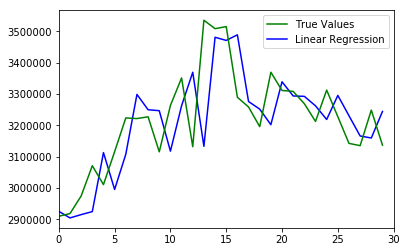

In [286]:
reg_val, = plt.plot(y_pred,color='b',label=u'Linear Regression')
true_val, = plt.plot(y_true,color='g', label='True Values')
plt.xlim([0,30])
plt.legend(handles=[true_val,reg_val])
plt.show()

In [91]:
lr = LinearRegression(n_jobs=-1)

In [92]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [93]:
models = []
lr.fit(trainX,trainY)
models.append(lr)

In [120]:
models

[LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)]

In [94]:
trainPredict=models[0].predict(trainX)
trainPredict

array([ 0.21458716,  0.16008438,  0.14167122,  0.15181503,  0.21795963,
        0.33193138,  0.26077098,  0.38488724,  0.51175642,  0.50937043,
        0.51599893,  0.38423076,  0.55885707,  0.66231244,  0.40352907,
        0.87947569,  0.8477795 ,  0.85551621,  0.5895513 ,  0.55303387,
        0.47897349,  0.68373394,  0.61517978])

In [95]:
testPredict = models[0].predict(testX)
testPredict

array([ 0.49862538,  0.61661341,  0.51646227,  0.41598218,  0.40741449])

In [96]:
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
print(trainPredict)
print(trainY)

[ 3044261.74261412  3010149.27134237  2998624.75209747  3004973.60882467
  3046372.52333715  3117705.72591467  3073167.50399888  3150850.00369183
  3230255.52228293  3228762.16583983  3232910.84303601  3150439.12148558
  3259735.10951416  3324486.2698037   3162517.64910719  3460405.48708948
  3440567.31908821  3445409.60772581  3278946.16469474  3256090.45663209
  3209737.17468084  3337893.66886945  3294986.64490861]
[[ 2925574.88748314  2909954.86176975  2918559.93268179  2974670.91618132
   3071354.03456576  3010988.11762215  3116276.90380906  3223901.02381091
   3221876.96835621  3227499.97467028  3115720.00503606  3263856.86932484
   3351618.86331353  3132090.91891282  3535840.14177468  3508952.01848718
   3515515.12723155  3289895.02063726  3258917.00411012  3196091.00325128
   3369790.89406866  3311635.85928495  3308666.9262765 ]]


In [97]:
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
print(testPredict)
print(testY)

[ 3222036.99738139  3295883.9359003   3233200.83867675  3170311.85996187
  3164949.47284025]
[[ 3312852.02354003  3227893.02701972  3142654.98422247  3135386.94787798
   3248942.96499244]]


In [100]:
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 118837.25 RMSE
Test Score: 76607.23 RMSE


In [119]:
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back] = trainPredict

ValueError: could not broadcast input array from shape (23) into shape (23,1)

In [225]:
data = pd.read_csv('test/prime.csv',header=0,index_col=0).sort_index()

In [236]:
data.shape

(119, 1)

In [244]:
data.tail()

,Value
Date,
2014-07-31,15.2
2014-08-31,15.3
2014-09-30,15.3
2014-10-31,15.5
2014-11-30,15.6


In [227]:
x_data = []
y_data = []

In [228]:
# Creates a feature matrix with values from previous 6 months
for d in range(6,data.shape[0]):
    
    x = data.iloc[d-6:d].values.ravel()
    y = data.iloc[d].values[0]

    x_data.append(x)
    y_data.append(y)


x_data = np.array(x_data)
y_data = np.array(y_data)

In [243]:
data.iloc[2].values[0]

19.789999999999999

In [230]:
#Lists to store the predictions of the models
y_pred = []
y_pred_last = []
y_pred_ma = []
y_true = []

In [250]:
end

113

In [231]:
#Iterate over the time series creating a new model each month
end = y_data.shape[0]
for i in range(30,end):

    x_train = x_data[:i,:]
    y_train = y_data[:i]
    
    x_test = x_data[i,:]
    y_test = y_data[i]


    model = LinearRegression(normalize=True)
    model.fit(x_train,y_train)

    y_pred.append(model.predict(x_test.reshape(1, -1))[0])
    y_pred_last.append(x_test[-1])
    y_pred_ma.append(x_test.mean())
    y_true.append(y_test)

In [232]:
#Transforms the lists into numpy arrays
y_pred = np.array(y_pred)
y_pred_last = np.array(y_pred_last)
y_pred_ma = np.array(y_pred_ma)
y_true = np.array(y_true)

In [ ]:
x_train

In [233]:
#Print errors
print('\nMean Absolute Percentage Error')
print('MAPE Linear Regression', mape(y_pred,y_true))
print('MAPE Last Value Benchmark', mape(y_pred_last,y_true))
print('MAPE Moving Average Benchmark', mape(y_pred_ma,y_true))

print('\nMean Absolute Error')
print('MAE Linear Regression', mean_absolute_error(y_pred,y_true))
print('MAE Last Value Benchmark', mean_absolute_error(y_pred_last,y_true))
print('MAE Moving Average Benchmark', mean_absolute_error(y_pred_ma,y_true))


Mean Absolute Percentage Error
MAPE Linear Regression 1.87042556874
MAPE Last Value Benchmark 2.76774390378
MAPE Moving Average Benchmark 7.90386089172

Mean Absolute Error
MAE Linear Regression 0.284087187881
MAE Last Value Benchmark 0.427831325301
MAE Moving Average Benchmark 1.19851405622


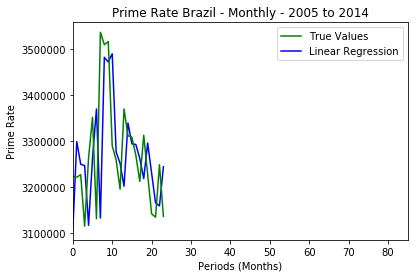

In [266]:
plt.title('Prime Rate Brazil - Monthly - 2005 to 2014')
plt.ylabel('Prime Rate')
plt.xlabel(u'Periods (Months)')
reg_val, = plt.plot(y_pred,color='b',label=u'Linear Regression')
true_val, = plt.plot(y_true,color='g', label='True Values')
plt.xlim([0,85])
plt.legend(handles=[true_val,reg_val])
plt.show()